In [3]:
# we load the things!

from ngsolve import *
#from netgen.csg import * 
from netgen.geom2d import SplineGeometry
from ngsolve.meshes import MakeStructured3DMesh

import netgen.gui

from netgen.occ import *
#from netgen.meshing import *

import matplotlib.pyplot as plt

import scipy.sparse as sp
from scipy.optimize import curve_fit
import numpy as np

import pandas as pd

ImportError: libOpenGL.so.0: cannot open shared object file: No such file or directory

In [ ]:
# custom logspace function
def logspace_custom_decades(start, stop, points_per_decade):
    
    result = []
    current_decade = start
    while current_decade < stop:
        decade_points = np.logspace(np.log10(current_decade), np.log10(current_decade * 10), points_per_decade, endpoint=False)
        result.extend(decade_points)
        current_decade *= 10
    return np.array(result)

In [ ]:
# functions for differential operators on manufactured solutions 

coords = [x,y,z]

def JacobianOfCF(cf):
    """ Function to compute the Jacobi Matrix of a vector coefficient function cf """

    Jac_u_3D = CF((
    cf[0].Diff(x), cf[0].Diff(y), cf[0].Diff(z),
    cf[1].Diff(x), cf[1].Diff(y), cf[1].Diff(z),
    cf[2].Diff(x), cf[2].Diff(y), cf[2].Diff(z)
    ), dims=(3, 3))

    return Jac_u_3D

def GGrad(cf):
    """ Function to compute the gradient of a scalar Coefficient Function """
    gg = [cf.Diff(coords[i]) for i in range(mesh.dim)]
    return CF(tuple(gg))


def GCurl(cf):
    """ Function to compute the curl or rot of vec cf using Jacobian """

    if cf.dim == 1: # if the functions is getting handed a scalar field, its to calculate the curl of the rot..
        curl_rot_u = CF((cf.Diff(y), - cf.Diff(x)))
        return curl_rot_u

    elif mesh.dim == 2:
        rot_u = CF(cf[1].Diff(x) - cf[0].Diff(y))
        return rot_u
    
    elif mesh.dim == 3:
        Jac_u = JacobianOfCF(cf)
        curl_u = CF((Jac_u[2,1] - Jac_u[1,2],  
                    Jac_u[0,2] - Jac_u[2,0],  
                    Jac_u[1,0] - Jac_u[0,1]))
        return curl_u
    

def GDiv(cf):
    """ Function to compute the divergence of a vector coefficient function """

    gd = [cf[i].Diff(coords[i]) for i in range(cf.dim)]
    return CF(sum(gd))

def curl_a_times_b(a,b):
    """ Returns curl(a) x b """
    a_Jac = Grad(a)
    
    c0 = a_Jac[2, 1] - a_Jac[1, 2]  # (curl(a))[0]
    c1 = a_Jac[0, 2] - a_Jac[2, 0]  # (curl(a))[1]
    c2 = a_Jac[1, 0] - a_Jac[0, 1]  # (curl(a))[2]      

    cxb0 = c1 * b[2] - c2 * b[1]
    cxb1 = c2 * b[0] - c0 * b[2]
    cxb2 = c0 * b[1] - c1 * b[0]

    curlAtimesB = CF((cxb0, cxb1, cxb2))

    return curlAtimesB

NameError: name 'x' is not defined

In [ ]:
# Functions for plotting, least squares regression fit line for convergence

def reference_line_func(h_values, scaling_factor, slope):

    return scaling_factor * h_values ** slope

def fit_reference_line(h_values, error_values):

    popt, _ = curve_fit(reference_line_func, h_values, error_values, p0=[1, 1])

    scaling_factor, slope = popt
    return scaling_factor, slope

In [ ]:
# Functions to calculate h_max

def edge_length(v1, v2, dim):
    return np.sqrt(sum((v1[i] - v2[i])**2 for i in range(dim)))

def squared_distance(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return np.sum((v1 - v2) ** 2)

def cayley_menger_matrix(vertices):
    if len(vertices) != 4:
        raise ValueError("This method is for a tetrahedron, which requires exactly 4 vertices.")

    # Create the Cayley-Menger matrix (5x5)
    C = np.ones((5, 5))
    for i in range(5):
        C[i, i] = 0 

    for i in range(1, 5):
        for j in range(i+1, 5):
            C[i, j] = C[j, i] = squared_distance(vertices[i-1], vertices[j-1])

    return C

def triangle_area(a, b, c):
    s = (a + b + c) / 2  
    return np.sqrt(s * (s - a) * (s - b) * (s - c))

def circumradius_2D(a, b, c):
    area = triangle_area(a, b, c)
    return a * b * c / (4 * area)

def circumradius_3D(vertices):
    C = cayley_menger_matrix(vertices)

    try:
        C_inv = np.linalg.inv(C)
    except np.linalg.LinAlgError:
        raise ValueError("Cayley-Menger matrix is singular or not invertible.")

    M = -2 * C_inv
    circumradius = 0.5 * np.sqrt(M[0, 0])

    return circumradius

def calc_hmax(mesh):
    max_h = 0 
    if mesh.dim == 2:
        for el in mesh.Elements():
            vertices = [mesh[v].point for v in el.vertices]
            a = edge_length(vertices[0], vertices[1], 2)
            b = edge_length(vertices[1], vertices[2], 2)
            c = edge_length(vertices[2], vertices[0], 2)
            circumradius = circumradius_2D(a, b, c)
            max_h = max(max_h, circumradius)
    
    elif mesh.dim == 3:
        for el in mesh.Elements():
            vertices = [mesh[v].point for v in el.vertices]
            circumradius = circumradius_3D(vertices)
            max_h = max(max_h, circumradius)
    
    return max_h

In [ ]:
# Functions to create geometries, unstrucuted reentrant corner and structured unit brick 

def createGeometry(hmax):
    """ Given h_max, this function returns an unstructured mesh on the reentrant corner in 3D """

    largeBrick = Box(Pnt(-0.5, -0.5,-0.5), Pnt(0.5, 0.5, 0.5))
    smallBrick = Box(Pnt(-0.5, -0.5,-0.5), Pnt(0, 0, 0))

    reentrantCornerGeo3D = largeBrick - smallBrick
    # Here instead of the following mesh command, I think I need to implement a structured mesh with the manual mesh generation approach.
    mesh = Mesh(OCCGeometry(reentrantCornerGeo3D).GenerateMesh(maxh=hmax))

    return mesh

def createStructuredGeometry(n):
    """ Given n, this functions returns a structured mesh with n elements along each dimnsion on the unit brick """
    mesh =  MakeStructured3DMesh(hexes=False, nx=n, ny=n, nz=n)
    return mesh



In [ ]:
# def hodgeLaplace1Forms(mesh,
#                        g = None, # this is the manufactured solution, when none is given we set it to the zero solution
#                        order = 1,
#                        C_w = 1):
    
#     if g is None:
#         g = CF((0,0,0))

#     h_curl = HCurl(mesh, order=order, type1=True)  # For 1-forms, H(curl)
#     h_1 = H1(mesh, order=order)     # For 0-forms, H1 space
#     fes = h_curl * h_1
#     (u, p), (v, q) = fes.TnT()

#     B = BilinearForm(fes)

#     B += u * grad(q) * dx
#     B += - p * q * dx
    
#     B +=  grad(p) * v * dx
#     B +=  curl(u) * curl(v) * dx

#     n = specialcf.normal(mesh.dim)
#     t = specialcf.tangential(mesh.dim)
#     h = specialcf.mesh_size

#     ### TILL HERE ALL IS GOOD ###

#     gamma_p_v = v - n*(v*n)
#     gamma_p_u = u - n*(u*n)
#     gamma_n_u = Cross(n, curl(u))
#     gamma_n_v = Cross(n, curl(v))

#     curlu = curl(u)
#     curlv = curl(v)
#     curl_u_times_v = Cross(curlu, v)
#     curl_v_times_u = Cross(curlv, u)

#     B += curl_u_times_v * n * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
#     B += curl_v_times_u * n * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
#     B += C_w/h * u.Trace() * v.Trace() * ds
    
#     f = CF(GCurl(GCurl(g)) - GGrad(GDiv(g))) 

#     rhs = LinearForm(fes)
#     rhs += f * v * dx

#     gamma_p_u_m = g - n*(g*n)
#     #curl_v_times_u_m = CF((curlv[1]*g[2] - curlv[2]*g[1], curlv[2]*g[0] - curlv[0]*g[2], curlv[0]*g[1] - curlv[1]*g[0]))
#     curl_v_times_u_m = Cross(curlv, g)
#     rhs += (C_w / h) * gamma_p_u_m * gamma_p_v * ds(skeleton=True)
#     #rhs +=  gamma_p_u_m  * gamma_n_v * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
#     #rhs += (C_w / h) * gamma_p_u_m * v.Trace() * ds
#     rhs += curl_v_times_u_m * n * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
#     rhs +=  g * n * q * ds(skeleton=True, definedon=mesh.Boundaries(".*"))

#     with TaskManager():
#         B.Assemble()
#         rhs.Assemble()
#         sol = GridFunction(fes)
#         res = rhs.vec-B.mat * sol.vec
#         inv = B.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
#         sol.vec.data += inv * res

#     gf_u , gf_p = sol.components

#     #curl_u = CF(Grad(gf_u)[1,0] - Grad(gf_u)[0,1])
#     curl_u = curl(gf_u)
#     grad_p = grad(gf_p)

#     curl_u_m = CF(GCurl(g))
#     p_m = - CF(GDiv(g))
#     grad_p_m = CF(GGrad(p_m))

#     gf_gamma_p_u = CF(gf_u - n*(gf_u*n))
#     gf_gamma_p_u_m = CF(g - n*(g*n))

#     gf_gamma_n_u = BoundaryFromVolumeCF(Cross(n, curl_u))
#     gf_gamma_n_u_m = BoundaryFromVolumeCF(Cross(n, curl_u_m))

#     gf_u_n = CF(gf_u * n)
#     gf_u_n_m = CF(g * n)

#     L2_error_u = sqrt(Integrate((gf_u - g)**2, mesh))
#     L2_error_curl_u = sqrt(Integrate((curl_u - curl_u_m)**2, mesh))
#     L2_error_p = sqrt(Integrate((gf_p - p_m)**2, mesh))
#     L2_error_grad_p = sqrt(Integrate((grad_p - grad_p_m)**2, mesh))

#     L2_error_gamma_p_u = sqrt(Integrate((gf_gamma_p_u - gf_gamma_p_u_m)**2 * ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh))
#     L2_error_u_n = sqrt(Integrate((gf_u_n - gf_u_n_m)**2 * ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh))
#     L2_error_p_gamma = sqrt(Integrate((gf_p - p_m)**2 * ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh))

#     # terms for the hashtag error!
#     h_avg = 1 / Integrate(1, mesh, VOL) * Integrate(h, mesh, VOL)

#     HT_error_gamma_p = Integrate(h_avg**(-1)*(gf_gamma_p_u - gf_gamma_p_u_m)**2 * ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh)
#     HT_error_gamma_n = Integrate(h_avg*(gf_gamma_n_u - gf_gamma_n_u_m)**2 * ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh)
#     HT_error_u = sqrt(L2_error_u**2 + L2_error_curl_u**2 + HT_error_gamma_p + HT_error_gamma_n) 
#     #HT_error_u = HT_error_gamma_n

#     return fes.ndof, Norm(res), L2_error_u, L2_error_curl_u, L2_error_p, L2_error_grad_p, L2_error_gamma_p_u, L2_error_u_n, L2_error_p_gamma, HT_error_u, sqrt(HT_error_gamma_n), sqrt(HT_error_gamma_p)

In [ ]:
def hodgeLaplace1Forms(mesh,
                       g = None, # this is the manufactured solution, when none is given we set it to the zero solution
                       order = 1,
                       C_w = 1):
    
    if g is None:
        g = CF((0,0,0))

    h_curl = HCurl(mesh, order=order, type1=True)  # For 1-forms, H(curl)
    h_1 = H1(mesh, order=order)     # For 0-forms, H1 space
    fes = h_curl * h_1
    (u, p), (v, q) = fes.TnT()

    n = specialcf.normal(mesh.dim)
    h = specialcf.mesh_size

    u_x_n = Cross(u, n)
    v_x_n = Cross(v, n)
    g_x_n = Cross(g, n)

    curlu = curl(u)
    curlv = curl(v)

    g_Trace = g - g*(n*g)
    
    f = CF(GCurl(GCurl(g)) - GGrad(GDiv(g)))

    B = BilinearForm(fes)
    F = LinearForm(fes)

    B += curl(u) * curl(v) * dx
    B += v * grad(p) * dx

    B += u * grad(q) * dx
    B += - p * q * dx

    B += C_w / h * u.Trace() * v.Trace() * ds
    B += curlu * v_x_n * ds(skeleton=True)
    B += curlv * u_x_n * ds(skeleton=True)
   
    F += f * v * dx
    F += C_w / h * g_Trace * v.Trace() * ds
    F += curlv * g_x_n * ds(skeleton=True)
    F += g * n * q * ds(skeleton=True)

    with TaskManager():
        B.Assemble()
        F.Assemble()
        sol = GridFunction(fes)
        res = F.vec-B.mat * sol.vec
        inv = B.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
        sol.vec.data += inv * res

    gf_u , gf_p = sol.components

    curl_u = curl(gf_u)
    grad_p = grad(gf_p)

    curl_g = CF(GCurl(g))
    p_m = - CF(GDiv(g))
    grad_p_m = CF(GGrad(p_m))

    # gf_gamma_p_u = CF(gf_u - n*(gf_u*n))
    # gf_gamma_p_g = CF(g - n*(g*n))
    gf_gamma_p_u = CF(Cross(n, Cross(gf_u, n)))
    gf_gamma_p_g = CF(Cross(n, Cross(g, n)))

    gf_gamma_n_u = BoundaryFromVolumeCF(Cross(n, curl_u))
    gf_gamma_n_u_m = BoundaryFromVolumeCF(Cross(n, curl_g))

    gf_u_n = CF(gf_u * n)
    gf_g_n = CF(g * n)

    L2_error_u = sqrt(Integrate((gf_u - g)**2, mesh))
    L2_error_curl_u = sqrt(Integrate((curl_u - curl_g)**2, mesh))
    L2_error_p = sqrt(Integrate((gf_p - p_m)**2, mesh))
    L2_error_grad_p = sqrt(Integrate((grad_p - grad_p_m)**2, mesh))

    L2_error_gamma_p_u = sqrt(Integrate((gf_gamma_p_u - gf_gamma_p_g)**2 * ds(skeleton=True), mesh))
    L2_error_u_n = sqrt(Integrate((gf_u_n - gf_g_n)**2 * ds(skeleton=True), mesh))
    L2_error_p_gamma = sqrt(Integrate((gf_p - p_m)**2 * ds(skeleton=True), mesh))

    # terms for the hashtag error
    h_avg = 1 / Integrate(1, mesh, VOL) * Integrate(h, mesh, VOL)

    HT_error_gamma_p = Integrate(h_avg**(-1)*(gf_gamma_p_u - gf_gamma_p_g)**2 * ds(skeleton=True), mesh)
    HT_error_gamma_n = Integrate(h_avg*(gf_gamma_n_u - gf_gamma_n_u_m)**2 * ds(skeleton=True), mesh)
    HT_error_u = sqrt(L2_error_u**2 + L2_error_curl_u**2 + HT_error_gamma_p + HT_error_gamma_n)
    #HT_error_u = HT_error_gamma_n

    return fes.ndof, Norm(res), L2_error_u, L2_error_curl_u, L2_error_p, L2_error_grad_p, L2_error_gamma_p_u, L2_error_u_n, L2_error_p_gamma, HT_error_u, sqrt(HT_error_gamma_n), sqrt(HT_error_gamma_p)

In [ ]:
# definition of manufactured solutions

#omega_m_sinusoids_3D = CF(( -cos(x)*sin(y)*cos(z), 
                            #sin(x)*cos(y)*sin(z),
                            #-cos(x)*sin(y)*cos(z)))

omega_m_sinusoids_3D = CF((z**2, 12*cos(1/3*x), sin(x)+2*y**4))

In [ ]:
# Data Generation

saveBigCSV = False

refinementVals = [12, 14, 16]
h_max_init = 0.5
maxh_values = [] 

Cw_vals = logspace_custom_decades(1, 50, 10)
#Cw_vals = np.linspace(2, 5, 3)
#Cw_vals = [10]

orders = [1]

all_results = []

for refinementVal in refinementVals:
    mesh = createStructuredGeometry(refinementVal)
    h_max_eval = calc_hmax(mesh)
    maxh_values.append(h_max_eval)
    print("doing h_max: ", h_max_eval)

    for order_cw in orders:
        results_cw = []
        print("doing order: ", order_cw)

        for C_w in Cw_vals:
            g = omega_m_sinusoids_3D

            ndof, res, L2_error_u, L2_error_curl_u, L2_error_p, L2_error_grad_p, L2_error_gamma_p_u, L2_error_u_n, L2_error_p_Gamma, HT_error_u, HT_error_gamma_n, HT_error_gamma_p = hodgeLaplace1Forms(
                mesh, g=g, order=order_cw, C_w=C_w
            )

            row_dict = {
                'order': order_cw,
                'hmax': h_max_eval,
                'C_w': C_w,
                'ndof': ndof,
                'res': res,
                'L2_error_u': L2_error_u,
                'L2_error_curl_u': L2_error_curl_u,
                'L2_error_p': L2_error_p,
                'L2_error_grad_p': L2_error_grad_p,
                'L2_error_gamma_p_u': L2_error_gamma_p_u,
                'L2_error_u_n': L2_error_u_n,
                'L2_error_p_Gamma': L2_error_p_Gamma,
                'HT_error_u': HT_error_u,
                'HT_error_gamma_n': HT_error_gamma_n,
                'HT_error_gamma_p': HT_error_gamma_p
            }
            all_results.append(row_dict)

df_all_results = pd.DataFrame(all_results)

if (saveBigCSV == True):
    df_all_results.to_csv("all_3D_1forms_simulation_results.csv", index=False)

doing h_max:  0.07216878364870326
doing order:  1
doing h_max:  0.06185895741317426
doing order:  1
doing h_max:  0.05412658773652741
doing order:  1


/tmp/ipykernel_42251/61658106.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(reference_line_func, h_values, error_values, p0=[1, 1])


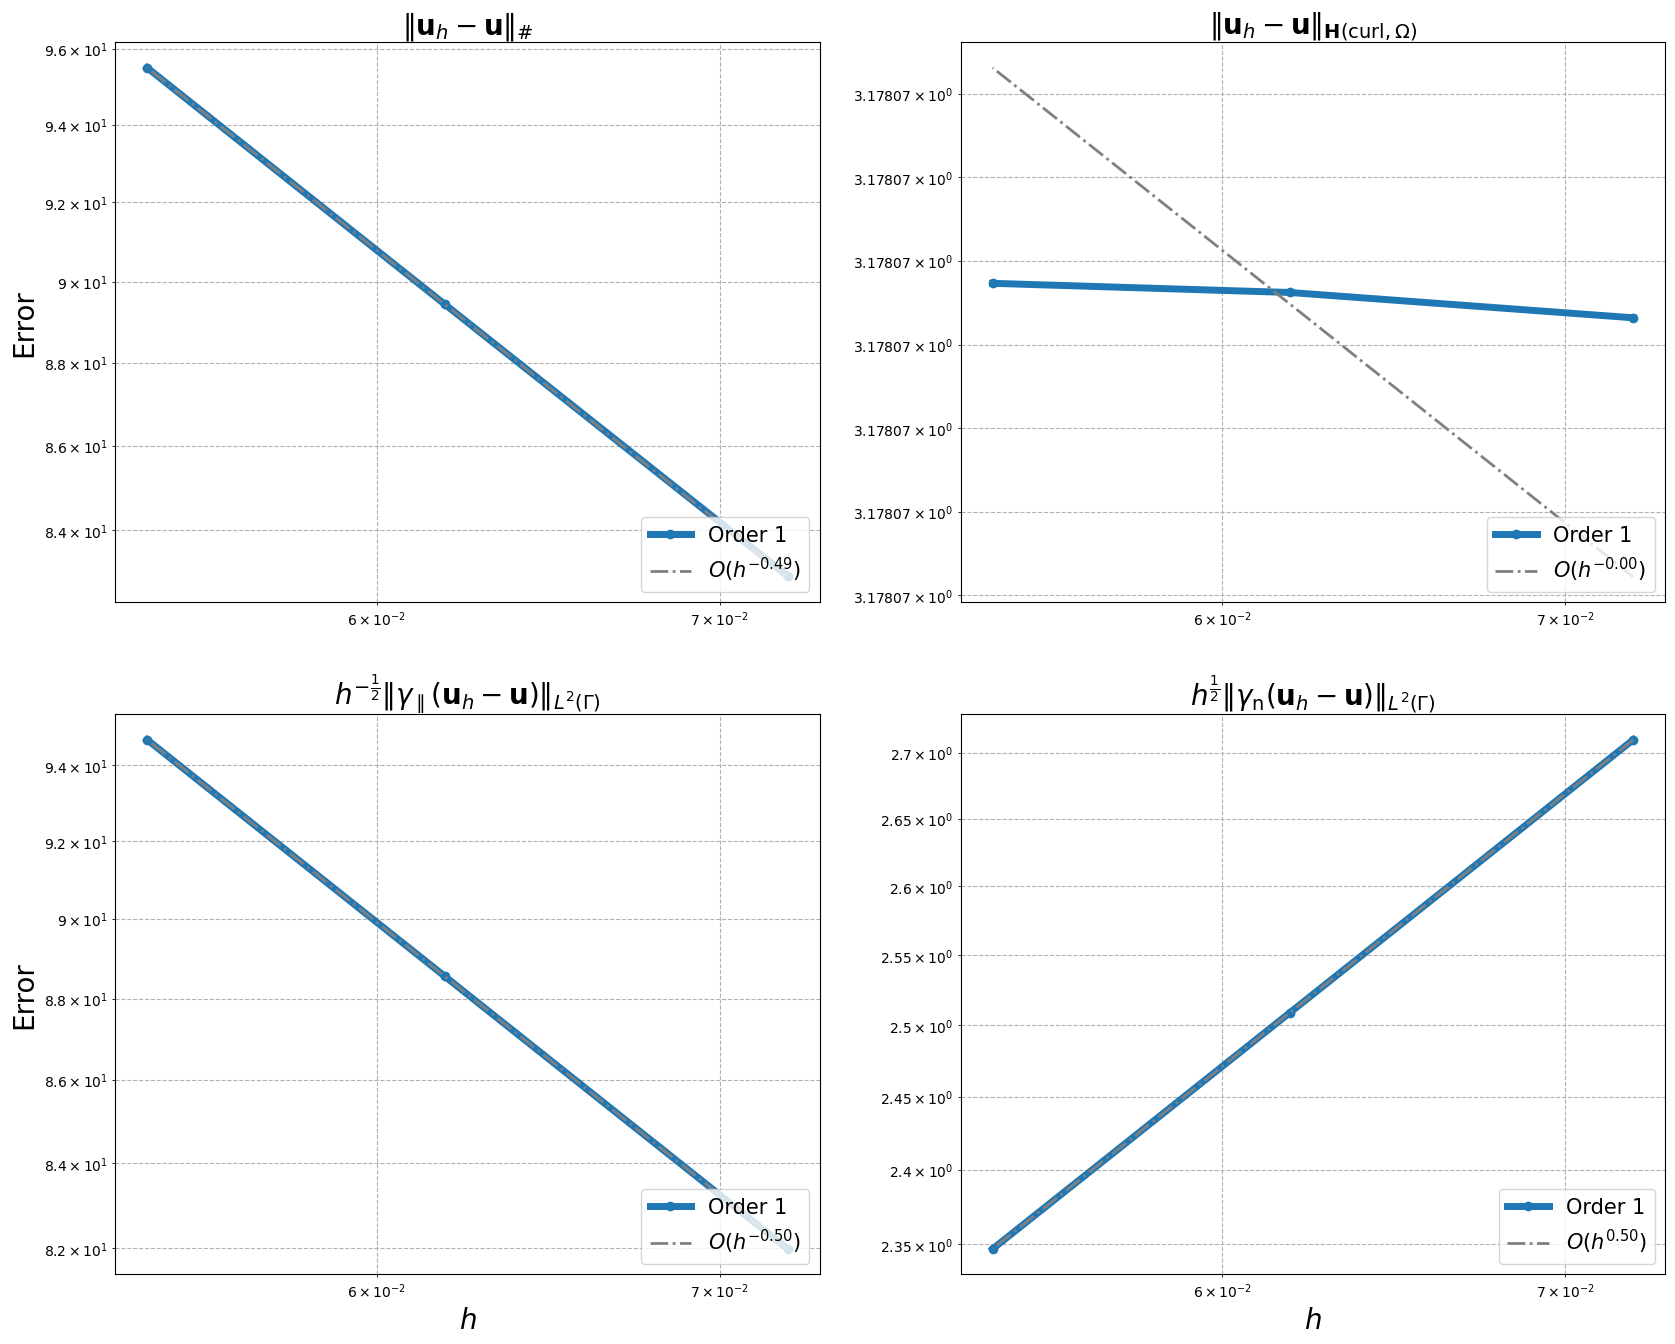

In [ ]:
color1, color2, color3, color4, color5  = "#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"

line_width = 5
font_size = 20

h_list = df_all_results['hmax'].unique()
order_list = df_all_results['order'].unique()
Cw_list = df_all_results['C_w'].unique()
nDof_list = df_all_results['ndof'].unique()


# Determine which C_w minimizes the L2 error of u per order
optimal_cw_per_order = {}
for order_cw in order_list:
    subset = df_all_results[df_all_results['order'] == order_cw]
    min_error_index = subset['L2_error_u'].idxmin()
    optimal_cw_per_order[order_cw] = subset.loc[min_error_index, 'C_w']

# For each order and hmax, pick the row corresponding to the optimal C_w
filtered_results = []
for order_cw in order_list:
    for hmax in h_list:
        group = df_all_results[
            (df_all_results['order'] == order_cw) &
            (df_all_results['hmax'] == hmax) &
            (df_all_results['C_w'] == optimal_cw_per_order[order_cw])
        ]
        if not group.empty:
            filtered_results.append(group.iloc[0])

df_filtered = pd.DataFrame(filtered_results)

# Define the error columns and their LaTeX titles
error_columns = [
    'HT_error_u',
    'L2_error_curl_u',
    'HT_error_gamma_p',
    'HT_error_gamma_n'
]
error_titles = [
    r'$\Vert \mathbf{u}_h - \mathbf{u} \Vert_{\#}$',
    r'$\Vert \mathbf{u}_h - \mathbf{u} \Vert_{\mathbf{H}(\mathrm{curl},\Omega)}$',
    r'$ h^{-\frac{1}{2}} \Vert \gamma_{\parallel}(\mathbf{u}_h - \mathbf{u}) \Vert_{L^2(\Gamma)}$',
    r'$ h^{\frac{1}{2}} \Vert \gamma_{\mathrm{n}}(\mathbf{u}_h - \mathbf{u}) \Vert_{L^2(\Gamma)}$'
]
#print(filtered_results)

fig, axs = plt.subplots(2, 2, figsize=(20, 16))

for i, (err_col, err_title) in enumerate(zip(error_columns, error_titles)):
    row_idx = i // 2
    col_idx = i % 2
    ax = axs[row_idx, col_idx]
    
    # Plot the errors vs. h for each order
    for order_cw in order_list:
        order_group = df_filtered[df_filtered['order'] == order_cw]
        h_values = order_group['hmax'].values
        error_values = order_group[err_col].values

        # Plot the data points
        ax.plot(h_values, error_values, label=f'Order {int(order_cw)}', marker='o', linewidth=line_width)

        if len(h_values) >= 2:
            h_fit_values = h_values[-2:]
            error_fit_values = error_values[-2:]
            try:
                scaling_factor, slope = fit_reference_line(h_fit_values, error_fit_values)
                ref_values = scaling_factor * (h_values ** slope)
                ax.plot(
                    h_values, 
                    ref_values, 
                    linestyle='dashdot', 
                    color='gray',
                    linewidth = (line_width - 3),
                    label = f"$O(h^{{{slope:.2f}}})$"
                )
            except RuntimeError as e:
                # If fit_reference_line fails (e.g., curve_fit can't converge), just skip
                print(f"Warning: Slope fit failed for order {order_cw} with error: {e}")

    ax.set_xscale('log')
    ax.set_yscale('log')
    # Set x-axis label only for bottom plots
    if row_idx == (axs.shape[0] - 1):
        ax.set_xlabel(r'$h$', fontsize=font_size)
    
    # Set y-axis label only for left column plots
    if col_idx == 0:
        ax.set_ylabel(r'Error', fontsize=font_size)
    ax.set_title(err_title, fontsize=font_size)
    ax.grid(True, which='both', linestyle='--')
    ax.legend(fontsize= font_size - 5, loc='lower right')
    ax.tick_params(axis='both', which='both', labelsize=font_size-10)

plt.show()